In [2]:
import math
import numpy.core as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.cluster import KMeans, BisectingKMeans, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.metrics import silhouette_score, pairwise_distances

from kneed import KneeLocator

from yellowbrick.cluster import KElbowVisualizer

from sklearn.neighbors import NearestNeighbors

from scipy.cluster import hierarchy

from scipy.spatial.distance import pdist, squareform

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES

In [3]:
#path dataset
path = "data/"
df = pd.read_csv(path + 'Dataset_forClustering.csv')

In [4]:
df.count()

duration_ms         17895
explicit            17895
popularity          17895
artists             17895
album_name          17895
danceability        17895
energy              17895
key                 17895
loudness            17895
speechiness         17895
acousticness        17895
instrumentalness    17895
liveness            17895
valence             17895
tempo               17895
time_signature      17895
n_beats             17895
n_bars              17895
processing          17895
genre               17895
genre_val           17895
dtype: int64

In [5]:
df.head()

duration_ms  explicit  popularity                 artists  \
0       241760     False          46           Funki Porcini   
1       444000     False           0           Siavash Amini   
2       333506     False           3               Kvelertak   
3       269800     False          23       The Wood Brothers   
4       307651     False          25  The Darkraver;DJ Vince   

               album_name  danceability  energy  key  loudness  speechiness  \
0           Hed Phone Sex         0.690   0.513    5   -12.529       0.0975   
1    A Trail of Laughters         0.069   0.196    1   -24.801       0.0805   
2              Nattesferd         0.363   0.854    2    -7.445       0.0397   
3       One Drop of Truth         0.523   0.585    5    -5.607       0.0765   
4  Happy Hardcore Top 100         0.643   0.687    7   -11.340       0.0539   

   ...  instrumentalness  liveness  valence    tempo  time_signature  n_beats  \
0  ...           0.53600     0.281   0.6350  142.221             4.0    567.0   
1  ...           0.93400     0.360   0.0336   75.596             4.0    617.0   
2  ...           0.80000     0.262   0.4890  116.628             4.0    652.0   
3  ...           0.00127     0.117   0.3850  140.880             4.0    619.0   
4  ...           0.09690     0.299   0.6370  143.956             4.0    733.0   

   n_bars  processing        genre genre_val  
0   141.0    1.279305      j-dance        14  
1   155.0    2.367412      iranian        13  
2   162.0    3.700483  black-metal         2  
3   155.0    1.279305    bluegrass         3  
4   183.0    4.067086        happy         9  

[5 rows x 21 columns]

In [6]:
df.dtypes

duration_ms           int64
explicit               bool
popularity            int64
artists              object
album_name           object
danceability        float64
energy              float64
key                   int64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
n_beats             float64
n_bars              float64
processing          float64
genre                object
genre_val             int64
dtype: object

In [7]:
df_train = df.drop(['artists', 'album_name', 'genre', 'genre_val', 'explicit', 'key', 'time_signature', 'processing'], axis=1)
features = df_train.columns

In [8]:
# Scaling dei dati
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_train)

# K-means

## Metodo SSE

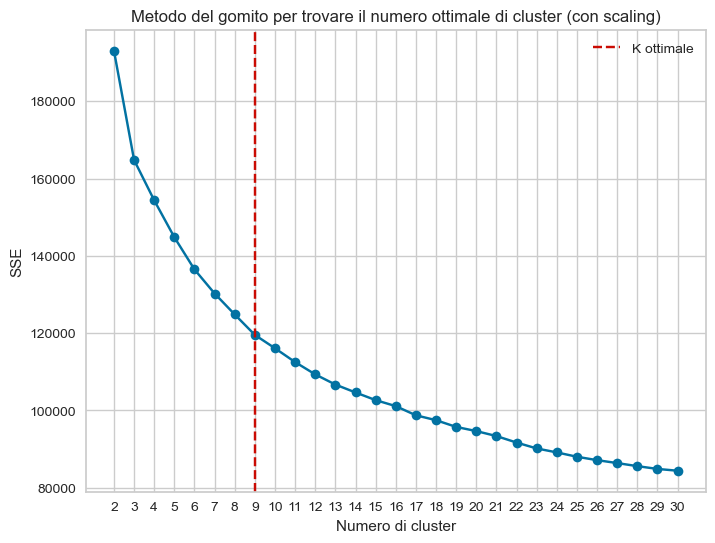

Numero ottimale di cluster secondo il metodo del gomito: 9


In [9]:
# Calcolo del SSE per diversi valori di k
sse = {}
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(scaled_features)
    sse[k] = kmeans.inertia_

# Plot del SSE
plt.figure(figsize=(8, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Numero di cluster")
plt.ylabel("SSE")
plt.xticks(range(2, 31))
plt.title("Metodo del gomito per trovare il numero ottimale di cluster (con scaling)")

# Utilizzando KneeLocator per identificare il gomito
kl = KneeLocator(
        range(2, 31), list(sse.values()), curve="convex", direction="decreasing"
    )


plt.axvline(x=kl.elbow, color='r', linestyle='--', label='K ottimale')
plt.legend()

plt.show()

print("Numero ottimale di cluster secondo il metodo del gomito:", kl.elbow)

il calcolo del k ottimale con il metodo SSE cambia in base al range di valori con il quale cerco di trovare il k migliore  
se k 2 a 10 allora k=4  
se k 2 a 20 allora k=6  
se k 2 a 30 allora k=10  

## Metodo Silhouette score

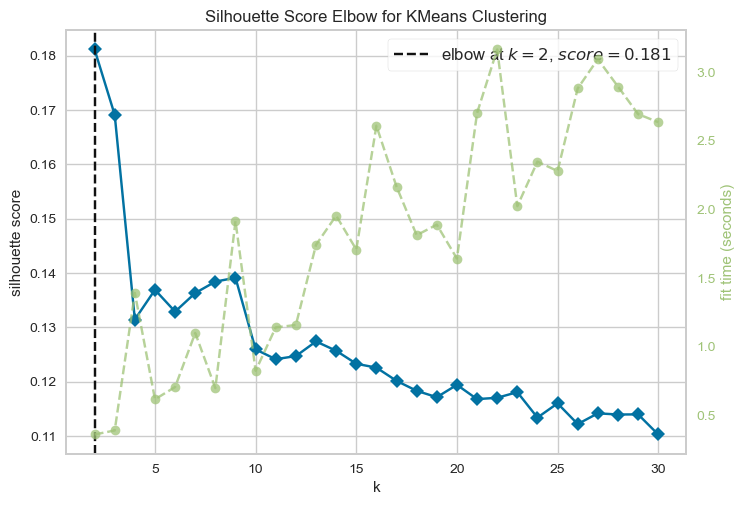

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [10]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(
        model, k=range(2, 31), metric='silhouette',locate_elbow=True
    )
visualizer.fit(scaled_features)
visualizer.show()

## Uso k ottimale = 8

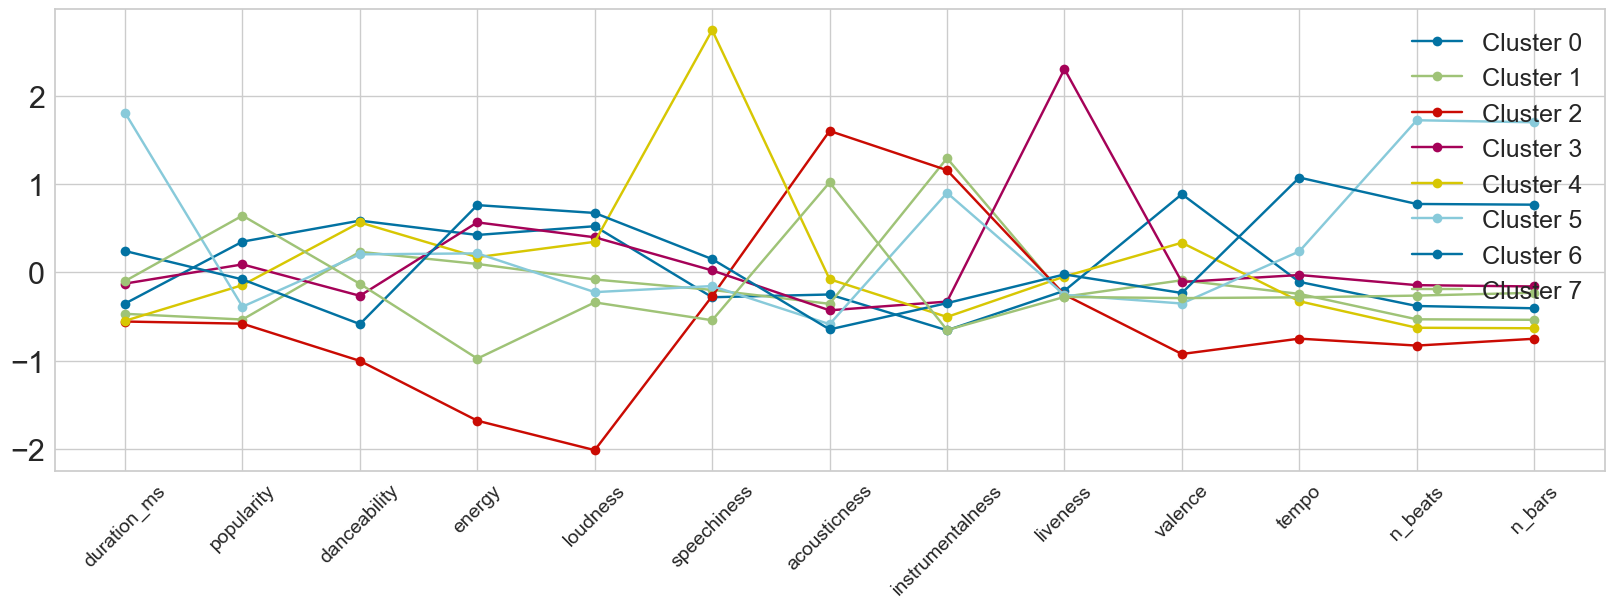

In [11]:
kmeans = KMeans(n_clusters=8, n_init=10).fit(scaled_features)

plt.figure(figsize=(20, 6))
for i in range(0, len(kmeans.cluster_centers_)):
    plt.plot(kmeans.cluster_centers_[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(features)), features, rotation=45, fontsize=14)
plt.legend(fontsize=18, loc='upper right')
plt.show()

voglio capire come sono distribuiti i punti nei cluster del k-means

In [12]:
cluster_labels = kmeans.labels_

df_afterDbscan = df_train.copy()
df_afterDbscan["clusters"] = cluster_labels
df_afterDbscan['clusters'].value_counts()

clusters
0    4103
6    2702
7    2665
5    2102
1    2012
2    1688
3    1403
4    1220
Name: count, dtype: int64

## 3d plot

In [13]:
df_plot3d = df_train.copy()
df_plot3d["clusters"] = kmeans.labels_

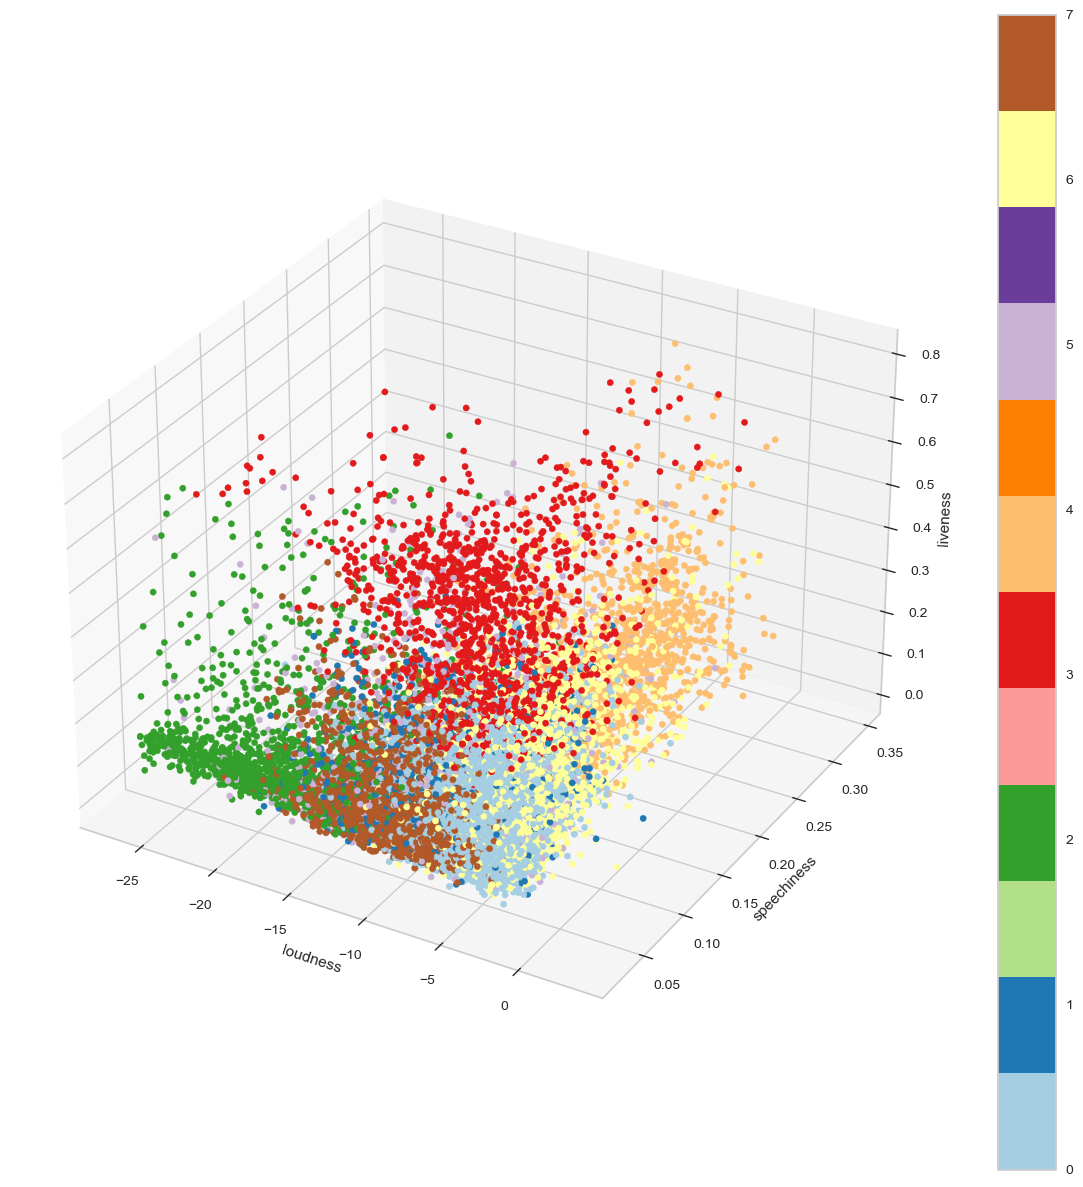

In [14]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d', facecolor='white')
x = df_plot3d['loudness']
y = df_plot3d['speechiness']
z = df_plot3d['liveness']

p = ax.scatter(x,y,z, marker="o", c=df_plot3d["clusters"], s=20, cmap="Paired", alpha=1)
fig.colorbar(p)
ax.set_xlabel('loudness')
ax.set_ylabel('speechiness')
ax.set_zlabel('liveness')
plt.show()

# X-Means

/Users/logan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/logan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/logan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/logan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

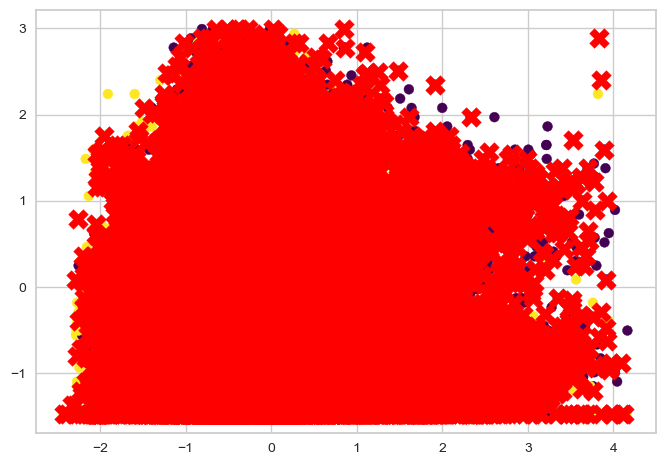

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


class XMeans:
    def __init__(self, k_init=2, **k_means_args):
        self.k_init = k_init
        self.k_means_args = k_means_args

    def fit(self, X):
        self.cluster_centers_ = []
        self.labels_ = np.zeros(X.shape[0])

        centroids = self._k_means(X, self.k_init)
        self.cluster_centers_.append(centroids)

        self.labels_ = self._assign_labels(X, centroids)

        for label in np.unique(self.labels_):
            cluster_data = X[self.labels_ == label]
            if len(cluster_data) <= self.k_init:
                continue
            x_means = XMeans(**self.k_means_args)
            x_means.fit(cluster_data)
            self.cluster_centers_.extend(x_means.cluster_centers_)

        self.cluster_centers_ = np.vstack(self.cluster_centers_)

    def _k_means(self, X, k):
        k_means = KMeans(n_clusters=k, **self.k_means_args)
        k_means.fit(X)
        return k_means.cluster_centers_

    def _assign_labels(self, X, centroids):
        labels = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            labels[i] = np.argmin(np.linalg.norm(X[i] - centroids, axis=1))
        return labels

# Addestra il modello X-Means
x_means = XMeans(random_state=42)
x_means.fit(scaled_features)

# Visualizza i cluster trovati
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=x_means.labels_, s=50, cmap='viridis')
plt.scatter(x_means.cluster_centers_[:, 0], x_means.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.show()


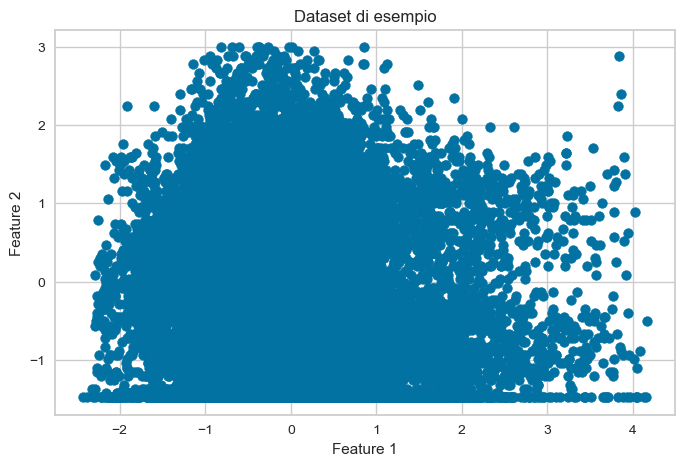

/Users/logan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/logan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/logan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/logan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

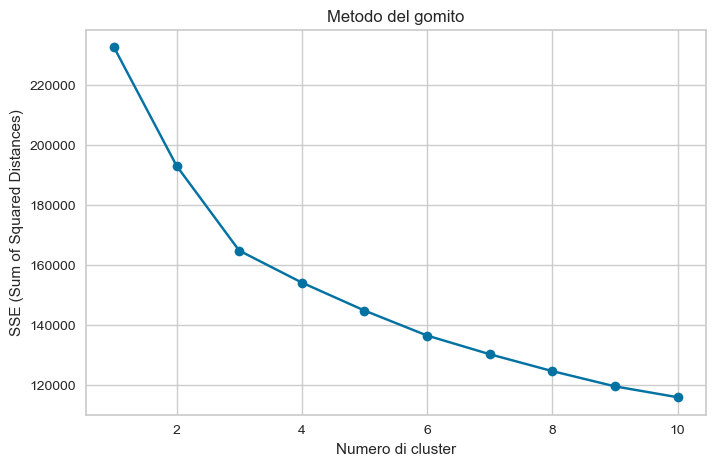

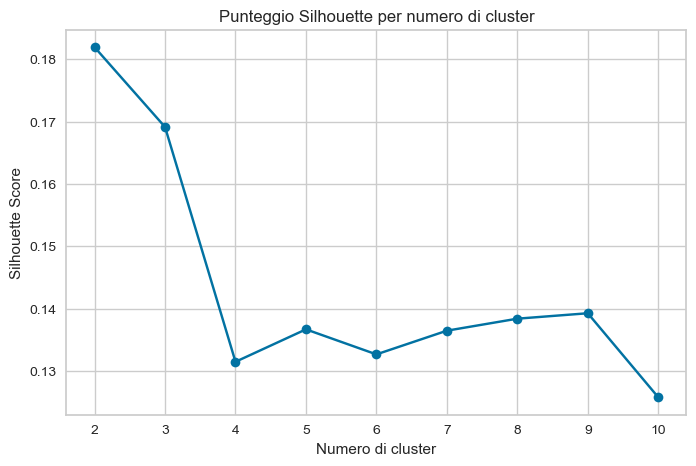

/Users/logan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


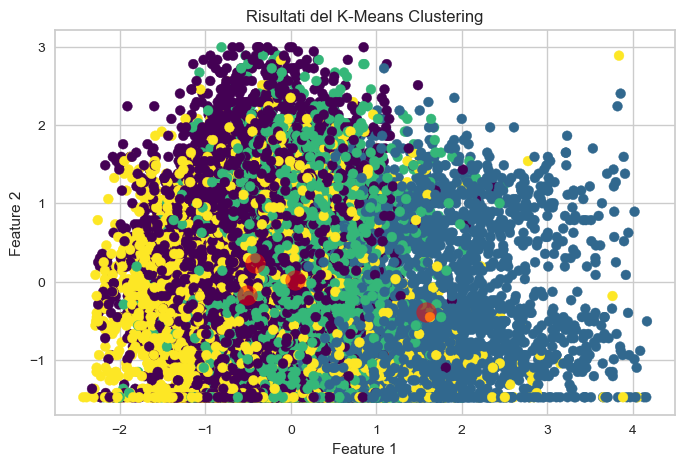

In [16]:
# Importare le librerie necessarie
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

X = scaled_features

# Visualizzare il dataset generato
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.title("Dataset di esempio")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Metodo del gomito per determinare il numero ottimale di cluster
sse = []
silhouette_scores = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Visualizzare il metodo del gomito
plt.figure(figsize=(8, 5))
plt.plot(K, sse, 'bo-')
plt.title('Metodo del gomito')
plt.xlabel('Numero di cluster')
plt.ylabel('SSE (Sum of Squared Distances)')
plt.show()

# Visualizzare il punteggio silhouette per ogni numero di cluster
plt.figure(figsize=(8, 5))
plt.plot(K[1:], silhouette_scores, 'bo-')
plt.title('Punteggio Silhouette per numero di cluster')
plt.xlabel('Numero di cluster')
plt.ylabel('Silhouette Score')
plt.show()

# Inizializzare l'algoritmo KMeans con il numero ottimale di cluster
optimal_clusters = 4  # Sostituire con il valore determinato dal metodo del gomito
kmeans = KMeans(n_clusters=optimal_clusters)

# Addestrare il modello sui dati
kmeans.fit(X)

# Ottenere i centri dei cluster
centroids = kmeans.cluster_centers_

# Predire i cluster per i dati
labels = kmeans.predict(X)

# Visualizzare i dati con i cluster colorati e i centri dei cluster
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)
plt.title('Risultati del K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Bisecting K-Means

## con k=8

In [17]:
# Creazione dell'istanza del modello Bisecting K-Means
bkm = BisectingKMeans(n_clusters=8, random_state=42)
bkm.fit(scaled_features)

# Etichette dei cluster
cluster_labels = bkm.labels_

# Centroidi dei cluster
centroids = bkm.cluster_centers_

In [18]:
# Calcolo del SSE
sse = sum(np.min(pairwise_distances(scaled_features, centroids, metric='euclidean'),axis=1))

# Calcolo della silhouette score
silhouette_avg = silhouette_score(scaled_features, cluster_labels)

print("SSE:", sse)
print("Silhouette Score:", silhouette_avg)

SSE: 46313.7903620113
Silhouette Score: 0.08239318873012176


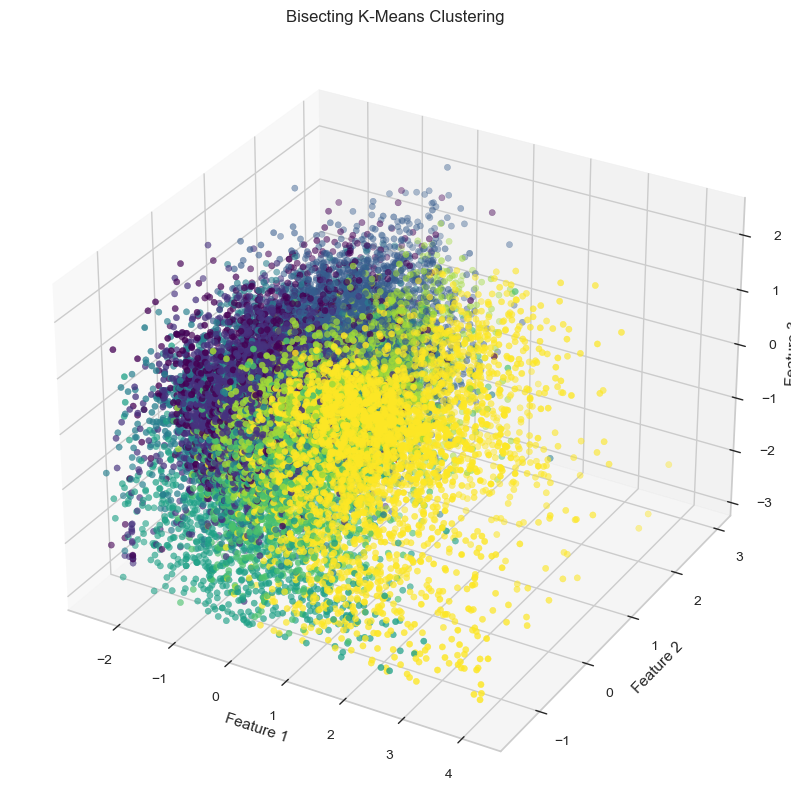

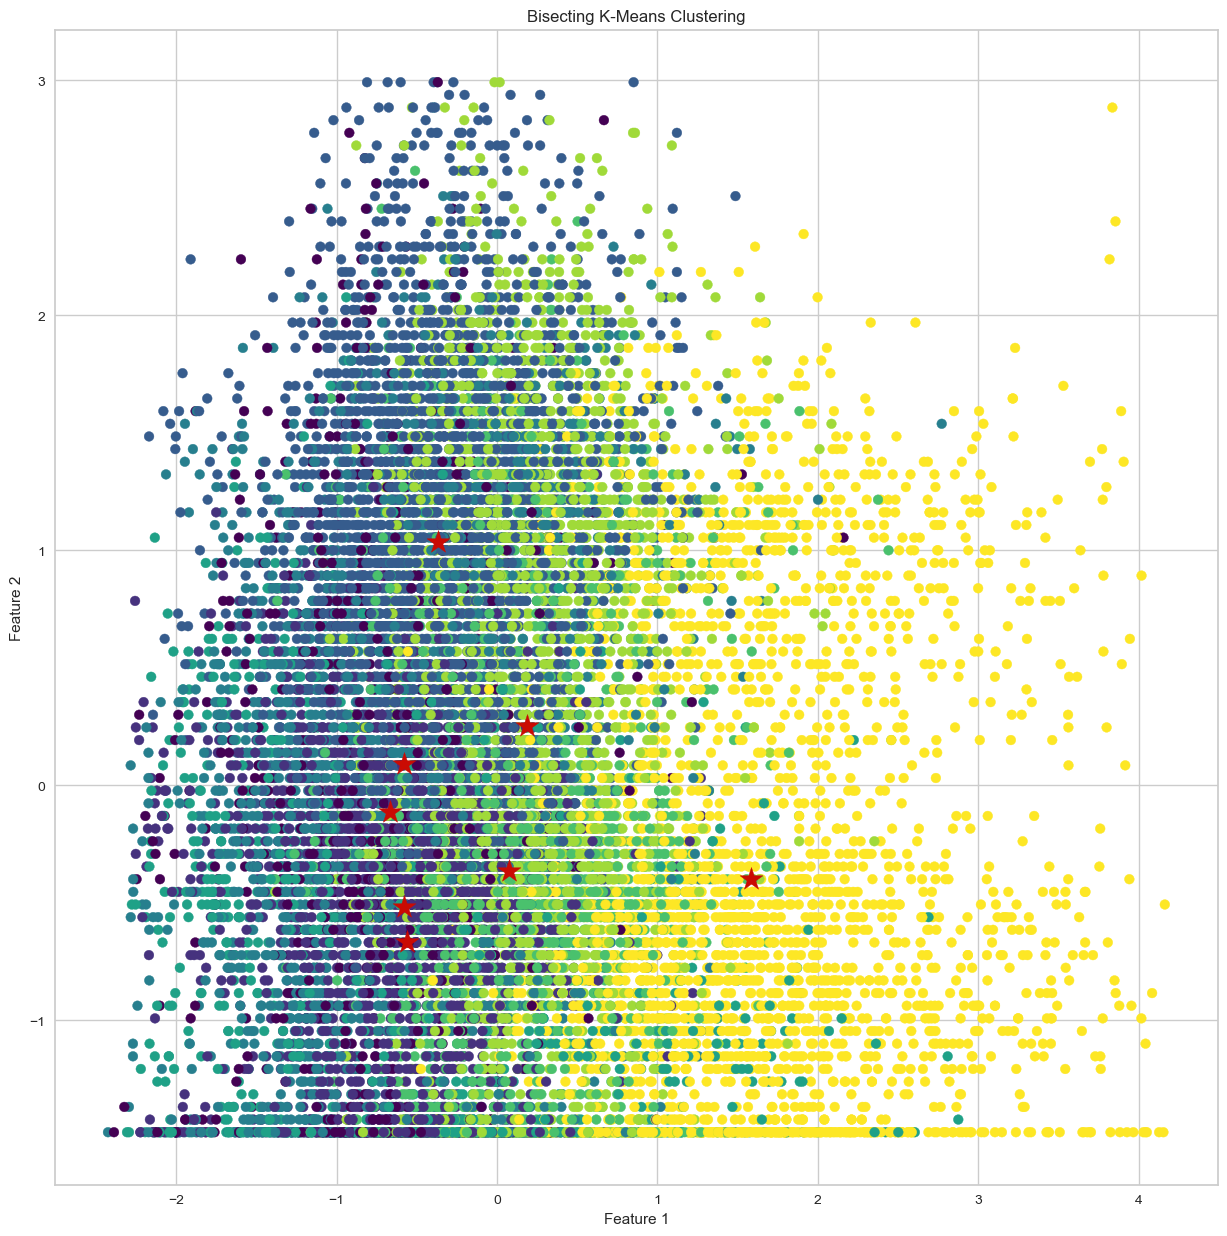

In [19]:
# Plot 3D dei cluster
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d', facecolor='white')
ax.scatter(scaled_features[:, 0], scaled_features[:, 1], scaled_features[:, 2], c=cluster_labels, cmap='viridis')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='*', c='r', s=300)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('Bisecting K-Means Clustering')
plt.show()

# Plot 2D dei cluster
plt.figure(figsize=(15, 15))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=cluster_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=300)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Bisecting K-Means Clustering')
plt.show()

## iterando i k da 1 a 15

Numero ottimale di cluster secondo il metodo del gomito per SSE: 4
Numero ottimale di cluster secondo il metodo del gomito per Silhouette Score: 7


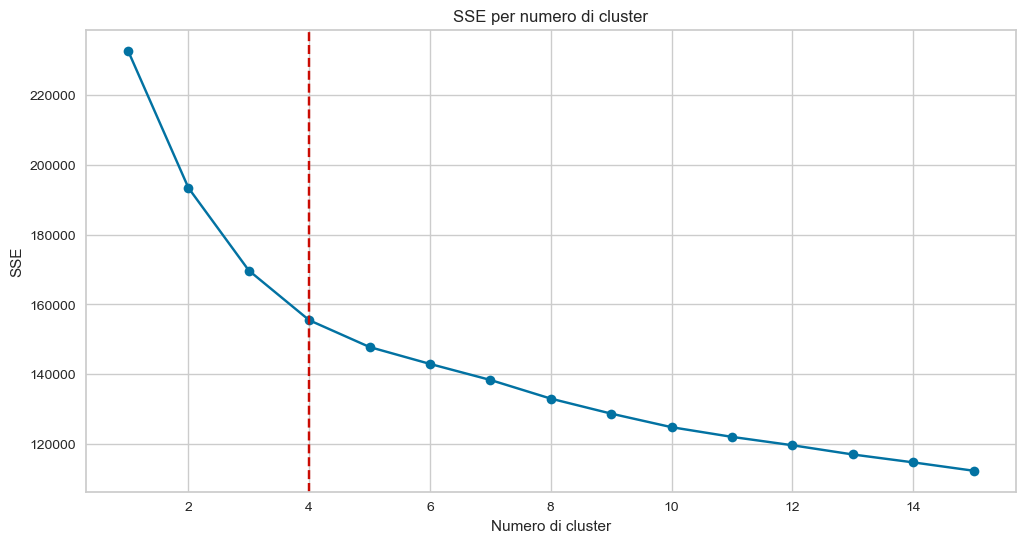

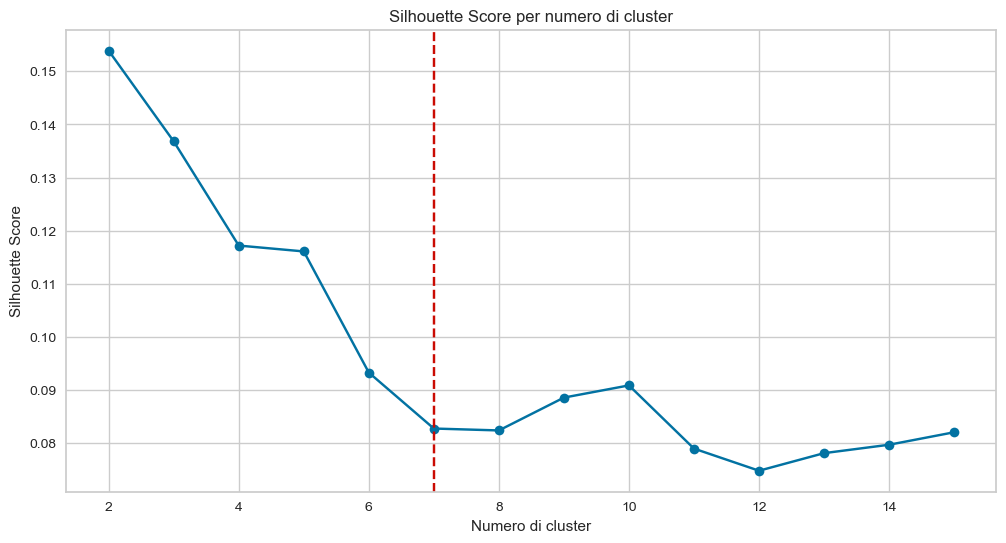

In [20]:
# Range di k
k_range = range(1, 16)

# Lista per salvare i valori SSE e silhouette
sse = []
silhouette_scores = []

# Iterazione su tutti i valori di k
for k in k_range:
    bkm = BisectingKMeans(n_clusters=k, random_state=42)
    bkm.fit(scaled_features)
    sse.append(bkm.inertia_)
    
    if k > 1:
        silhouette_scores.append(silhouette_score(scaled_features, bkm.labels_))

# Trova il numero ottimale di cluster utilizzando il metodo del gomito per SSE
kl_sse = KneeLocator(list(k_range), sse, curve="convex", direction="decreasing")
optimal_k_sse = kl_sse.elbow
print("Numero ottimale di cluster secondo il metodo del gomito per SSE:", optimal_k_sse)

# Trova il numero ottimale di cluster utilizzando il metodo del gomito per Silhouette Score
kl_silhouette = KneeLocator(list(k_range)[1:], silhouette_scores, curve="convex", direction="decreasing")
optimal_k_silhouette = kl_silhouette.elbow
print("Numero ottimale di cluster secondo il metodo del gomito per Silhouette Score:", optimal_k_silhouette)

# Plot SSE
plt.figure(figsize=(12, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Numero di cluster')
plt.ylabel('SSE')
plt.title('SSE per numero di cluster')
plt.axvline(x=optimal_k_sse, color='r', linestyle='--', label='K ottimale')
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(12, 6))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.xlabel('Numero di cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score per numero di cluster')
plt.axvline(x=optimal_k_silhouette, color='r', linestyle='--', label='K ottimale')
plt.show()


voglio capire come sono distribuiti i punti nei cluster con bisecting

In [21]:
bkm = BisectingKMeans(n_clusters=7, random_state=42)
bkm.fit(scaled_features)

BisectingKMeans(n_clusters=7, random_state=42)

In [22]:
cluster_labels = bkm.labels_

df_afterDbscan = df_train.copy()
df_afterDbscan["clusters"] = cluster_labels
df_afterDbscan['clusters'].value_counts()

clusters
3    3415
5    3020
2    2960
6    2852
1    2523
4    2015
0    1110
Name: count, dtype: int64

# DBSCAN

In [23]:
# Creazione dell'istanza del modello DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=5)

# Addestramento del modello
dbscan.fit(scaled_features)

# Etichette dei cluster
cluster_labels = dbscan.labels_

# Numero di cluster trovati
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print('Numero di cluster trovati:', n_clusters)
print('Numero di punti di rumore:', n_noise)

Numero di cluster trovati: 3
Numero di punti di rumore: 70


In [24]:
df_afterDbscan = df_train.copy()
df_afterDbscan["clusters"] = cluster_labels

In [25]:
df_afterDbscan = df_train.copy()
df_afterDbscan["clusters"] = cluster_labels
df_afterDbscan['clusters'].value_counts()

clusters
 0    17815
-1       70
 1        7
 2        3
Name: count, dtype: int64

## K-distance plot method

### Ricerca del miglior eps

Valore ottimale di eps: 1.92096992350529


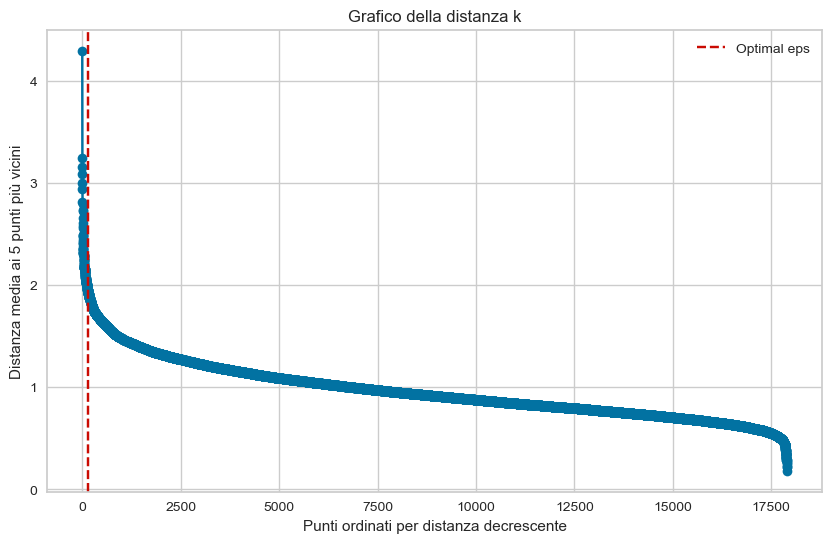

In [26]:
# Funzione per trovare il valore ottimale di eps
def find_optimal_eps(avg_distances_sorted, min_samples):
    kneedle = KneeLocator(range(len(avg_distances_sorted)), avg_distances_sorted, curve='convex', direction='decreasing')
    optimal_eps_index = kneedle.elbow
    optimal_eps = avg_distances_sorted[optimal_eps_index]
    return optimal_eps, optimal_eps_index

# Calcola le distanze medie dei min_samples punti più vicini
min_samples = 5  # Modifica il numero di min_samples a tuo piacimento
neigh = NearestNeighbors(n_neighbors=min_samples)
neigh.fit(scaled_features)
distances, indices = neigh.kneighbors(scaled_features)
avg_distances = np.mean(distances, axis=1)

# Ordina le distanze medie in ordine decrescente
avg_distances_sorted = np.sort(avg_distances)[::-1]

# Calcola il valore ottimale di eps
optimal_eps, curvature_index = find_optimal_eps(avg_distances_sorted, min_samples)
print("Valore ottimale di eps:", optimal_eps)

# Traccia il grafico della distanza k con il punto ottimale di eps evidenziato
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(avg_distances_sorted)), avg_distances_sorted, marker='o')
plt.axvline(x=curvature_index, color='r', linestyle='--', label='Optimal eps')
plt.xlabel('Punti ordinati per distanza decrescente')
plt.ylabel('Distanza media ai ' + str(min_samples) + ' punti più vicini')
plt.title('Grafico della distanza k')
plt.grid(True)
plt.legend()
plt.show()

Valore ottimale di eps: 2.5145575605585866


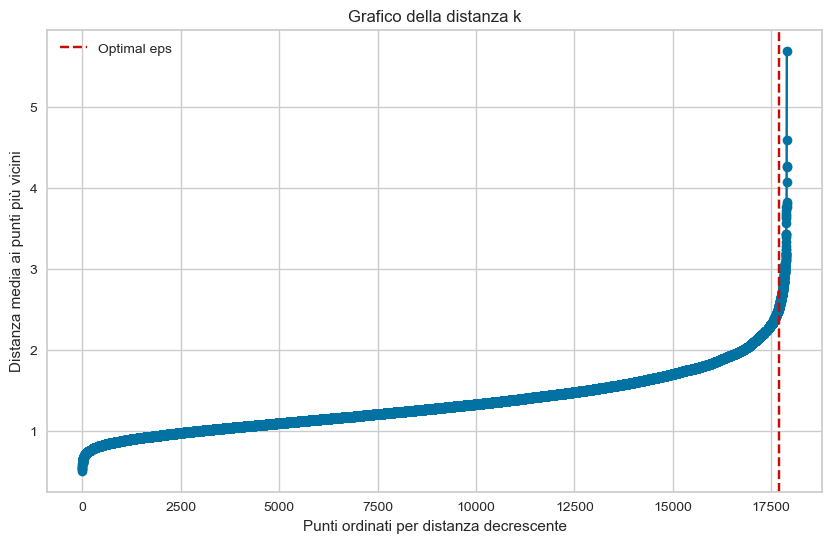

In [27]:
# Calcola la distanza media tra ogni punto e i suoi k punti più vicini
def calculate_avg_distances(data, k):
    # Calcola i k + 1 vicini più vicini, perché il punto stesso è incluso
    knn = NearestNeighbors(n_neighbors=k+1)
    knn.fit(data)
    # Trova le distanze ai k punti più vicini (il primo vicino è il punto stesso)
    distances, _ = knn.kneighbors(data)
    # Calcola la distanza media per ogni punto
    avg_distances = np.mean(distances[:, 1:], axis=1)
    return np.sort(avg_distances)


# Calcola le distanze medie
k = 10  # Numero di vicini da considerare
avg_distances = calculate_avg_distances(scaled_features, k)

# Trova il valore ottimale di eps utilizzando KneeLocator
kneedle = KneeLocator(range(len(avg_distances)), avg_distances, curve='convex', direction='increasing')
optimal_eps_index = kneedle.elbow
optimal_eps = avg_distances[optimal_eps_index]
print("Valore ottimale di eps:", optimal_eps)

# Traccia il grafico delle distanze medie
plt.figure(figsize=(10, 6))
plt.plot(range(len(avg_distances)), avg_distances, marker='o')
plt.axvline(x=optimal_eps_index, color='r', linestyle='--', label='Optimal eps')
plt.xlabel('Punti ordinati per distanza decrescente')
plt.ylabel('Distanza media ai punti più vicini')
plt.title('Grafico della distanza k')
plt.grid(True)
plt.legend()
plt.show()

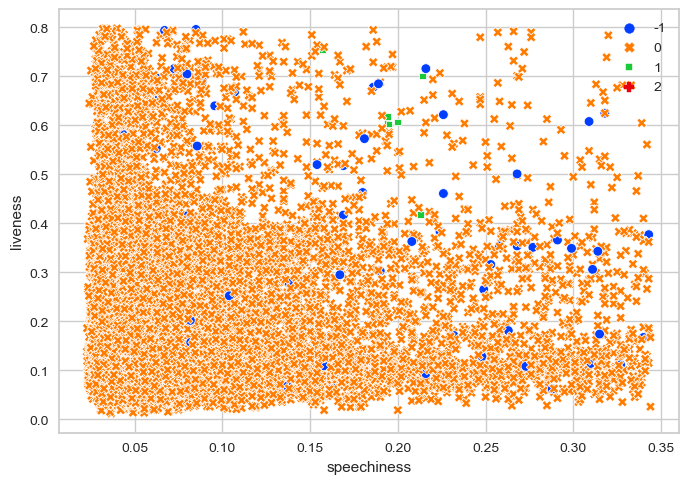

In [28]:
sns.scatterplot(data=df_train, 
                x="speechiness", 
                y="liveness", 
                hue=dbscan.labels_, 
                style=dbscan.labels_,
                palette="bright")
plt.show()

Valore ottimale di eps: 5.269219606090952


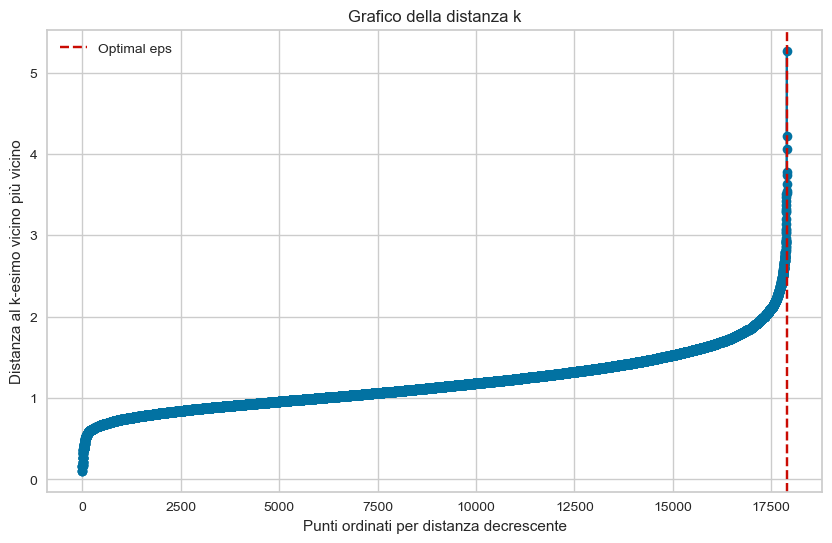

In [29]:
# Calcola la distanza al k-esimo vicino più vicino per ogni punto
def calculate_kth_distances(data, k):
    # Calcola i k + 1 vicini più vicini, perché il punto stesso è incluso
    knn = NearestNeighbors(n_neighbors=k+1)
    knn.fit(data)
    # Trova le distanze al k-esimo vicino più vicino (il primo vicino è il punto stesso)
    distances, _ = knn.kneighbors(data)
    # Seleziona le distanze al k-esimo vicino più vicino (l'ultimo vicino nella lista ordinata)
    kth_distances = distances[:, -1]
    return np.sort(kth_distances)

# Trova il valore ottimale di eps
def find_optimal_eps(kth_distances):
    # Calcola la derivata seconda della distanza k-esima
    curvature = np.gradient(np.gradient(kth_distances))
    # Trova il punto di massima curvatura
    optimal_eps_index = np.argmax(curvature)
    optimal_eps = kth_distances[optimal_eps_index]
    return optimal_eps, optimal_eps_index

# Calcola le distanze al k-esimo vicino più vicino
k = 2  # Numero di vicini da considerare
kth_distances = calculate_kth_distances(scaled_features, k)

# Trova il valore ottimale di eps
optimal_eps, optimal_eps_index = find_optimal_eps(kth_distances)
print("Valore ottimale di eps:", optimal_eps)

# Traccia il grafico delle distanze k
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(kth_distances)), kth_distances, marker='o')
plt.axvline(x=optimal_eps_index, color='r', linestyle='--', label='Optimal eps')
plt.xlabel('Punti ordinati per distanza decrescente')
plt.ylabel('Distanza al k-esimo vicino più vicino')
plt.title('Grafico della distanza k')
plt.grid(True)
plt.legend()
plt.show()

### Ricerco la combinazione ottima di eps e min_sample

Valore ottimale di eps: 1.92096992350529
Valore ottimale di min_samples: 5


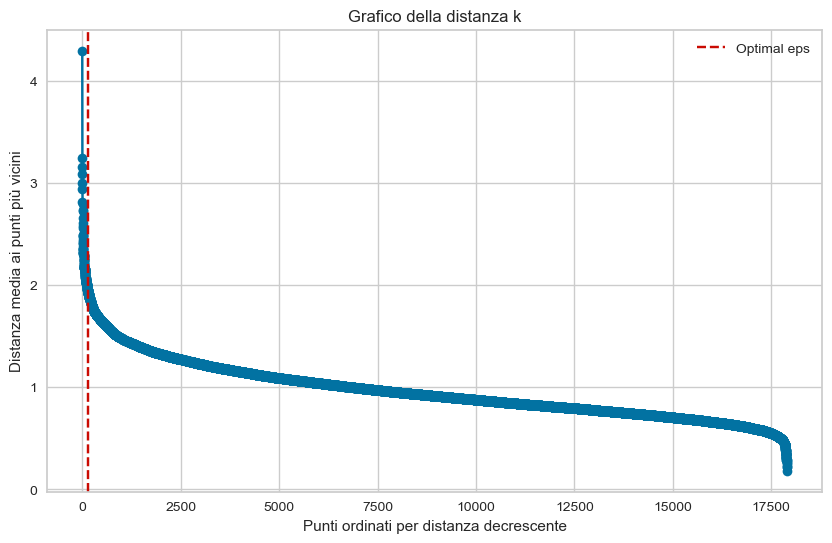

In [30]:
# Funzione per trovare il valore ottimale di eps e min_samples
def find_optimal_params(avg_distances_sorted, min_samples_range):
    max_silhouette_score = -1
    optimal_eps = None
    optimal_min_samples = None
    
    for min_samples in min_samples_range:
        kneedle = KneeLocator(range(len(avg_distances_sorted)), avg_distances_sorted, curve='convex', direction='decreasing')
        optimal_eps_index = kneedle.elbow
        eps = avg_distances_sorted[optimal_eps_index]
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_features)
        if len(np.unique(labels)) > 1:  # Evita il caso di un singolo cluster
            silhouette_score_value = silhouette_score(scaled_features, labels)
            if silhouette_score_value > max_silhouette_score:
                max_silhouette_score = silhouette_score_value
                optimal_eps = eps
                optimal_min_samples = min_samples
    
    return optimal_eps, optimal_min_samples, optimal_eps_index

# Calcola le distanze medie dei min_samples punti più vicini
min_samples = range(2, 6)  # Modifica il range di min_samples a tuo piacimento
neigh = NearestNeighbors(n_neighbors=max(min_samples))
neigh.fit(scaled_features)
distances, indices = neigh.kneighbors(scaled_features)
avg_distances = np.mean(distances, axis=1)

# Ordina le distanze medie in ordine decrescente
avg_distances_sorted = np.sort(avg_distances)[::-1]

# Calcola il valore ottimale di eps e min_samples
optimal_eps, optimal_min_samples, optimal_eps_index = find_optimal_params(avg_distances_sorted, min_samples)
print("Valore ottimale di eps:", optimal_eps)
print("Valore ottimale di min_samples:", optimal_min_samples)

# Traccia il grafico della distanza k con il punto ottimale di eps evidenziato
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(avg_distances_sorted)), avg_distances_sorted, marker='o')
plt.axvline(x=optimal_eps_index, color='r', linestyle='--', label='Optimal eps')
plt.xlabel('Punti ordinati per distanza decrescente')
plt.ylabel('Distanza media ai punti più vicini')
plt.title('Grafico della distanza k')
plt.grid(True)
plt.legend()
plt.show()

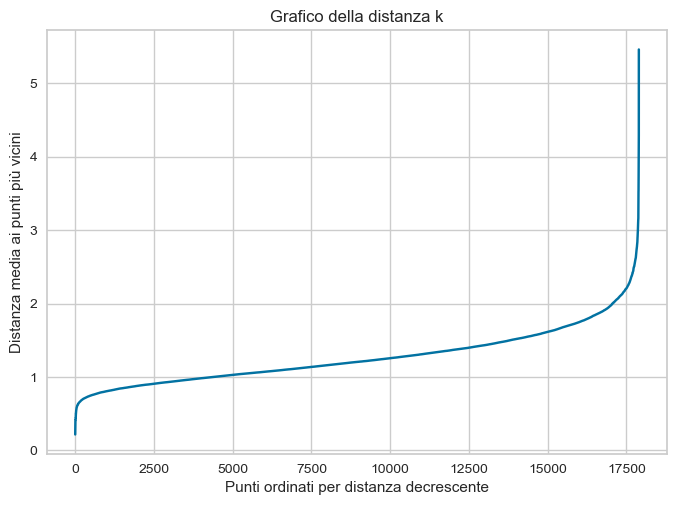

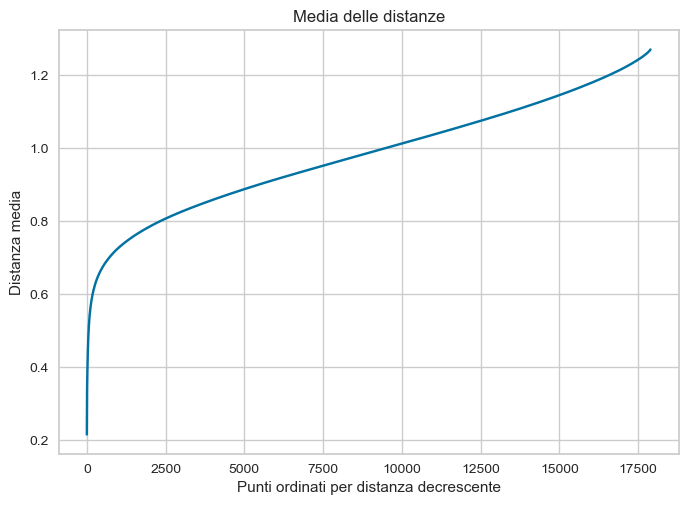

Valore ottimale di eps: 4.293857523620535


In [31]:
def find_optimal_eps(data, min_samples, metric='euclidean'):
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    distances = np.sort(distances[:, -1])

    # Plot della distanza media
    plt.plot(distances)
    plt.xlabel("Punti ordinati per distanza decrescente")
    plt.ylabel("Distanza media ai punti più vicini")
    plt.title("Grafico della distanza k")
    plt.grid(True)
    plt.show()

    # Calcola la media delle distanze
    avg_distances = []
    for i in range(1, len(distances)):
        avg_distances.append(np.mean(distances[:i]))

    # Plot della media delle distanze
    plt.plot(avg_distances)
    plt.xlabel("Punti ordinati per distanza decrescente")
    plt.ylabel("Distanza media")
    plt.title("Media delle distanze")
    plt.grid(True)
    plt.show()

    # Trova il punto di massima curvatura
    max_curvature_index = np.argmax(avg_distances)
    optimal_eps = distances[max_curvature_index]

    return optimal_eps

min_samples = 4
optimal_eps = find_optimal_eps(scaled_features, min_samples)
print("Valore ottimale di eps:", optimal_eps)

Valore ottimale di eps: 4.100642074544958


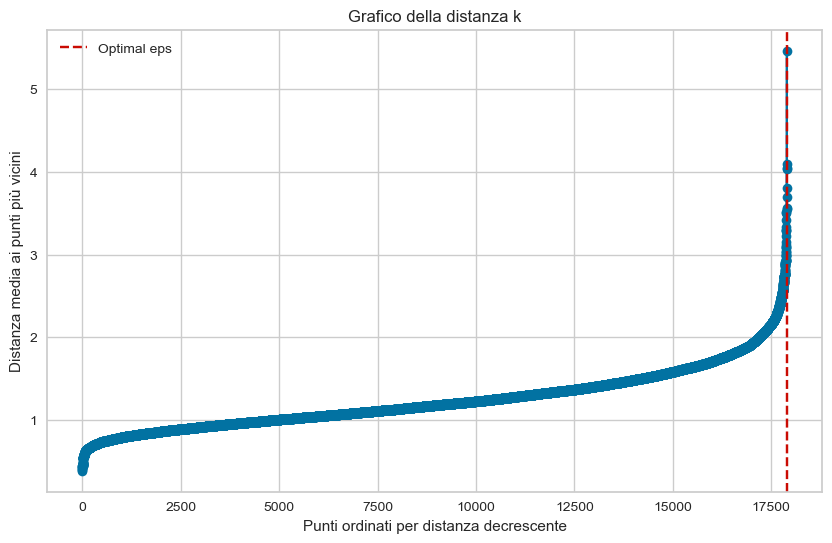

In [32]:
# Calcola la distanza media tra ogni punto e i suoi k punti più vicini
def calculate_avg_distances(data, k):
    # Calcola i k + 1 vicini più vicini, perché il punto stesso è incluso
    knn = NearestNeighbors(n_neighbors=k+1)
    knn.fit(data)
    # Trova le distanze ai k punti più vicini (il primo vicino è il punto stesso)
    distances, _ = knn.kneighbors(data)
    # Calcola la distanza media per ogni punto
    avg_distances = np.mean(distances[:, 1:], axis=1)
    return np.sort(avg_distances)

# Trova il punto di "gomito" nel grafico delle distanze medie
def find_optimal_eps(avg_distances):
    # Calcola la derivata seconda delle distanze medie
    curvature = np.gradient(np.gradient(avg_distances))
    # Trova il punto di massima curvatura
    optimal_eps_index = np.argmax(curvature)
    optimal_eps = avg_distances[optimal_eps_index]
    return optimal_eps, optimal_eps_index

# Calcola le distanze medie
k = 5  # Numero di vicini da considerare
avg_distances = calculate_avg_distances(scaled_features, k)

# Trova il valore ottimale di eps
optimal_eps, optimal_eps_index = find_optimal_eps(avg_distances)
print("Valore ottimale di eps:", optimal_eps)

# Traccia il grafico delle distanze medie
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(avg_distances)), avg_distances, marker='o')
plt.axvline(x=optimal_eps_index, color='r', linestyle='--', label='Optimal eps')
plt.xlabel('Punti ordinati per distanza decrescente')
plt.ylabel('Distanza media ai punti più vicini')
plt.title('Grafico della distanza k')
plt.grid(True)
plt.legend()
plt.show()

## Dbscan ottimo

### trovo eps e calcolo la silhouette per ogni eps

Migliore valore di eps: 2.800000000000001
Numero di cluster trovati: 2
Silhouette Score: 0.26981229324720124


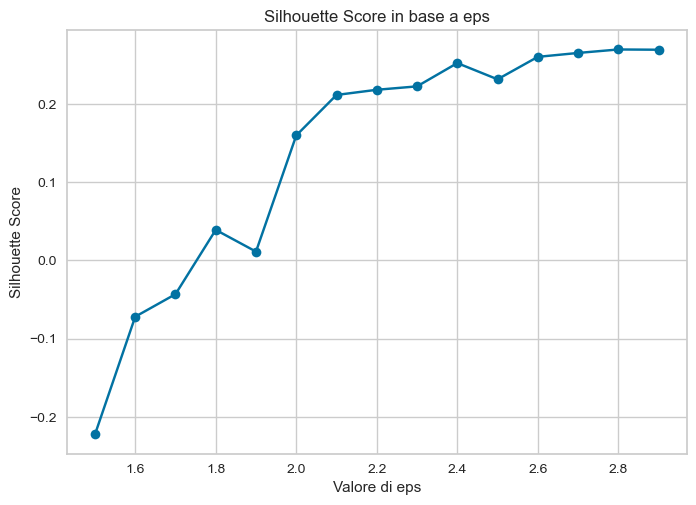

In [33]:
# Range di valori di eps
eps_values = np.arange(1.5, 3.4, 0.1)

# Valore di min_samples
min_samples = 5

best_eps = None
best_num_clusters = 0
best_silhouette_score = -1

# Inizializza le liste per salvare i valori di eps e silhouette score
eps_list = []
silhouette_scores = []

# Per ogni valore di eps, calcola il Silhouette Score
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(scaled_features)
    num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    
    # Calcola il Silhouette Score
    if num_clusters > 1:
        silhouette_avg = silhouette_score(scaled_features, dbscan.labels_)
        silhouette_scores.append(silhouette_avg)
        eps_list.append(eps)
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_eps = eps
            best_num_clusters = num_clusters

# Stampa il risultato
print("Migliore valore di eps:", best_eps)
print("Numero di cluster trovati:", best_num_clusters)
print("Silhouette Score:", best_silhouette_score)

# Traccia il grafico delle Silhouette Score in base a eps
plt.plot(eps_list, silhouette_scores, marker='o')
plt.xlabel('Valore di eps')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score in base a eps')
plt.grid(True)
plt.show()

### calcolo la miglior combinazione di eps, cluster e silhouette

Migliore valore di eps: 2.800000000000001
Numero di cluster trovati: 2
Silhouette Score: 0.26981229324720124


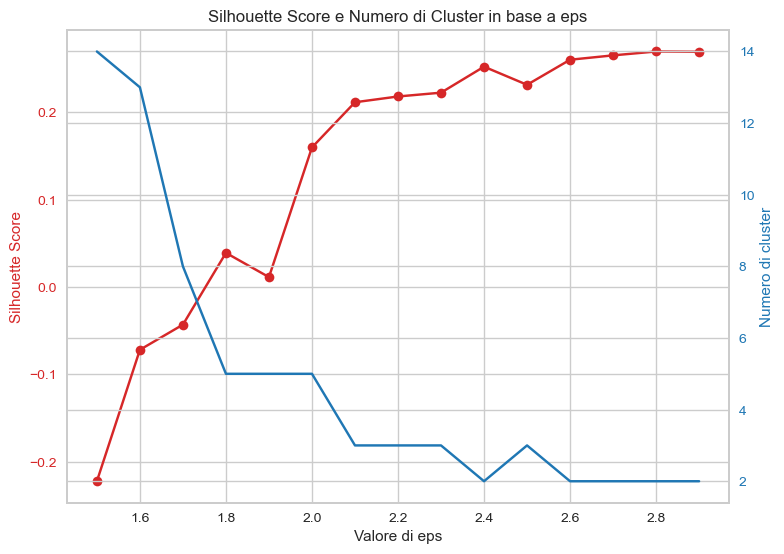

In [34]:
# Range di valori di eps
eps_values = np.arange(1.5, 3.4, 0.1)

# Valore di min_samples
min_samples = 5

best_eps = None
best_num_clusters = 0
best_silhouette_score = -1

# Inizializza le liste per salvare i valori di eps, silhouette score e numero di cluster
eps_list = []
silhouette_scores = []
num_clusters_list = []

# Per ogni valore di eps, calcola il Silhouette Score
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(scaled_features)
    num_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    
    # Calcola il Silhouette Score
    if num_clusters > 1:
        silhouette_avg = silhouette_score(scaled_features, dbscan.labels_)
        silhouette_scores.append(silhouette_avg)
        eps_list.append(eps)
        num_clusters_list.append(num_clusters)
        if silhouette_avg > best_silhouette_score:
            cluster_labels = dbscan.labels_
            best_silhouette_score = silhouette_avg
            best_eps = eps
            best_num_clusters = num_clusters

# Stampa il risultato
print("Migliore valore di eps:", best_eps)
print("Numero di cluster trovati:", best_num_clusters)
print("Silhouette Score:", best_silhouette_score)

# Traccia il grafico delle Silhouette Score in base a eps
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Valore di eps')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(eps_list, silhouette_scores, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Numero di cluster', color=color)  
ax2.plot(eps_list, num_clusters_list, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Silhouette Score e Numero di Cluster in base a eps')
plt.grid(True)
plt.show()

caso min_sample = 5: da qui si evince che il miglior valore di eps potrebbe essere 2.0 o 2.1 così avendo numero di cluster trovati k = 5 o k = 3 e un silhouette score di 0.17 o 0.21

In [35]:
# Creazione dell'istanza del modello DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=5)

# Addestramento del modello
dbscan.fit(scaled_features)

# Etichette dei cluster
cluster_labels = dbscan.labels_

# Numero di cluster trovati
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print('Numero di cluster trovati:', n_clusters)
print('Numero di punti di rumore:', n_noise)

Numero di cluster trovati: 5
Numero di punti di rumore: 423


In [36]:
df_afterDbscan = df_train.copy()
df_afterDbscan["clusters"] = cluster_labels
df_afterDbscan['clusters'].value_counts()

clusters
 0    17446
-1      423
 1        7
 3        7
 2        7
 4        5
Name: count, dtype: int64

# OPTICS

In [37]:
features

Index(['duration_ms', 'popularity', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'n_beats', 'n_bars'],
      dtype='object')

{0, -1}


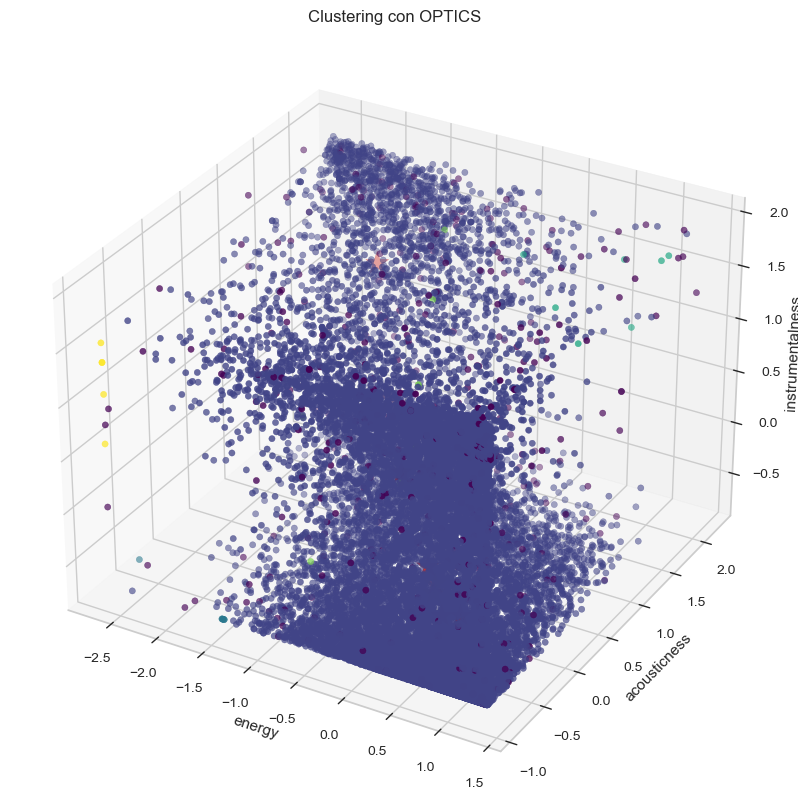

In [38]:
# Applica OPTICS
# min_cluster_size=0.1 indica che ogni cluster deve contenere almeno 100 punti per essere considerato valido
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1)
optics.fit(scaled_features)

# Ottieni le etichette dei cluster
labels = optics.labels_

print(set(labels))

# Aggiungi le etichette dei cluster al DataFrame originale
df_afterOptics = df_train.copy()
df_afterOptics['cluster'] = labels

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d', facecolor='white')
ax.scatter(scaled_features[:, 3], scaled_features[:, 6], scaled_features[:, 7], c=cluster_labels, cmap='viridis')
ax.scatter(centroids[:, 3], centroids[:, 6], centroids[:, 7], marker='*', c='r', s=300)
ax.set_xlabel('energy')
ax.set_ylabel('acousticness')
ax.set_zlabel('instrumentalness')
plt.title('Clustering con OPTICS')
plt.show()

trovo un solo cluster. Non ho trovato niente di meglio rispetto al DBSCAN

# Hierarchical clustering

## Agglomerative (bottom-up)

1. Calcolo delle distanze: Calcola la matrice delle distanze tra tutti i punti del dataset.  
2. Costruzione della dendrogramma: Utilizza le distanze per costruire una dendrogramma che rappresenta la gerarchia dei cluster.  
3. Taglio della dendrogramma: Taglia la dendrogramma a un certo livello per ottenere i cluster desiderati.

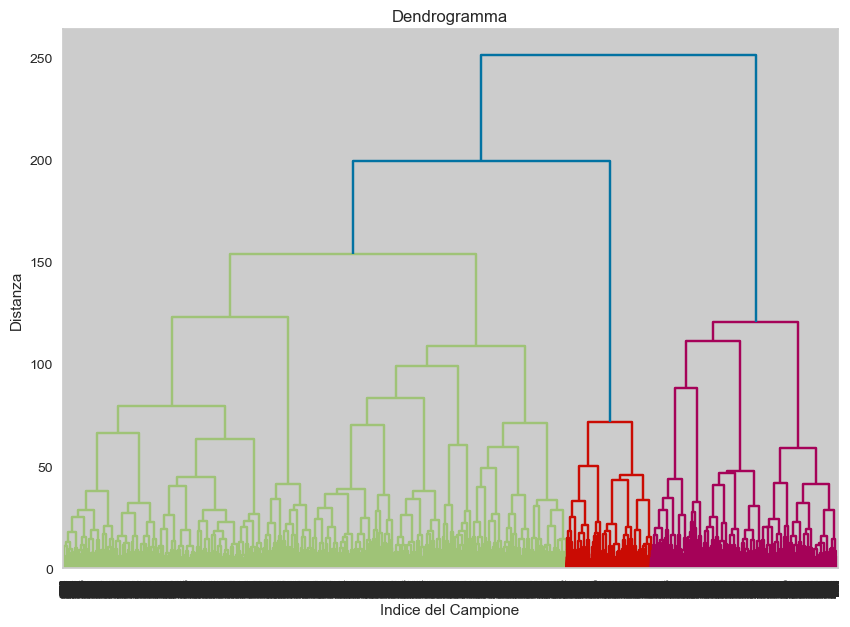

In [44]:
# Costruzione del dendrogramma
linked = linkage(scaled_features, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogramma')
plt.xlabel('Indice del Campione')
plt.ylabel('Distanza')
plt.show()

# Determinazione dei cluster tagliando il dendrogramma
# Qui specifichiamo che vogliamo ottenere 3 cluster
num_clusters = 4
clusters = fcluster(linked, num_clusters, criterion='maxclust')

# Aggiungi i cluster al dataframe originale
df_afterHier = df_train.copy()
df_afterHier['cluster'] = clusters

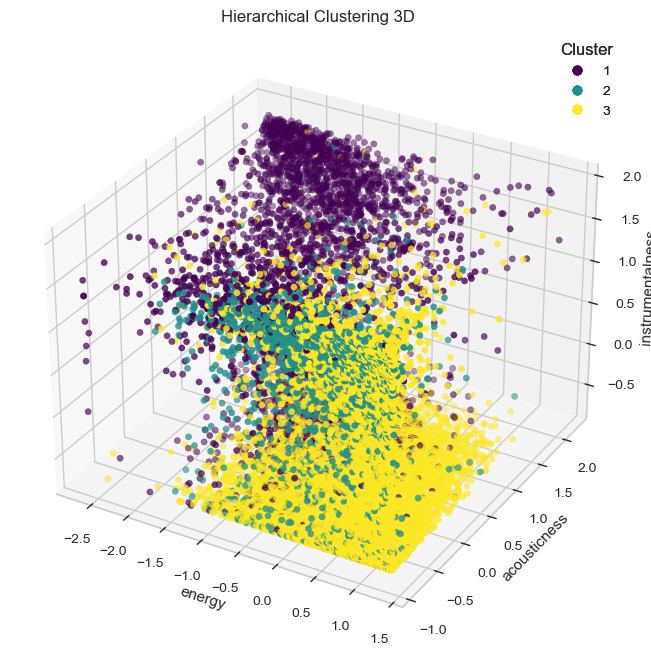

In [40]:
# Visualizzazione dei cluster
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(scaled_features[:, 3], scaled_features[:, 6], scaled_features[:, 7], c=clusters, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend)
ax.set_xlabel('energy')
ax.set_ylabel('acousticness')
ax.set_zlabel('instrumentalness')
plt.title('Hierarchical Clustering 3D')
plt.show()

## Divisive (top-down)

# Export DF

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17895 entries, 0 to 17894
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration_ms       17895 non-null  int64  
 1   popularity        17895 non-null  int64  
 2   danceability      17895 non-null  float64
 3   energy            17895 non-null  float64
 4   loudness          17895 non-null  float64
 5   speechiness       17895 non-null  float64
 6   acousticness      17895 non-null  float64
 7   instrumentalness  17895 non-null  float64
 8   liveness          17895 non-null  float64
 9   valence           17895 non-null  float64
 10  tempo             17895 non-null  float64
 11  n_beats           17895 non-null  float64
 12  n_bars            17895 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 1.8 MB


In [43]:
df.to_csv(r''+path+'DatasetClean.csv', index = False)